# Play with HRET (high res empirical tide) model

Data is available on Ed Zaron's website [here](http://web.cecs.pdx.edu/~zaron/pub/Downloads.html)

In [139]:
!pip install JSAnimation

  Running setup.py bdist_wheel for JSAnimation: started
  Running setup.py bdist_wheel for JSAnimation: finished with status 'done'
  Stored in directory: C:\Users\mrayson\AppData\Local\pip\Cache\wheels\3c\c2\b2\b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [1]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

from scipy.fftpack import fft2, ifft2, fftfreq


In [4]:
%matplotlib notebook

In [53]:
ds = xr.open_dataset(r'C:\Users\mrayson\cloudstor\Data\HRET\HRET_v8.1_compressed.nc')
ds = ds.sel(longitude=slice(110,125),latitude=slice(-22,-8))
ds

<xarray.Dataset>
Dimensions:    (latitude: 281, longitude: 301)
Coordinates:
  * longitude  (longitude) float64 110.0 110.0 110.1 110.1 ... 124.9 124.9 125.0
  * latitude   (latitude) float64 -22.0 -21.95 -21.9 -21.85 ... -8.1 -8.05 -8.0
Data variables:
    M2re       (latitude, longitude) float32 ...
    M2im       (latitude, longitude) float32 ...
    K1re       (latitude, longitude) float32 ...
    K1im       (latitude, longitude) float32 ...
    S2re       (latitude, longitude) float32 ...
    S2im       (latitude, longitude) float32 ...
    O1re       (latitude, longitude) float32 ...
    O1im       (latitude, longitude) float32 ...
    MA2re      (latitude, longitude) float32 ...
    MA2im      (latitude, longitude) float32 ...
    MB2re      (latitude, longitude) float32 ...
    MB2im      (latitude, longitude) float32 ...
Attributes:
    Conventions:              CF-1.7
    history:                  merged txa/j1a/j2a/j3a, txb/j1b/j2b, g1a, and e...
    resolution:             

In [58]:
amp = np.abs(ds.M2re+1j*ds.M2im)
idx = amp==0


<IPython.core.display.Javascript object>


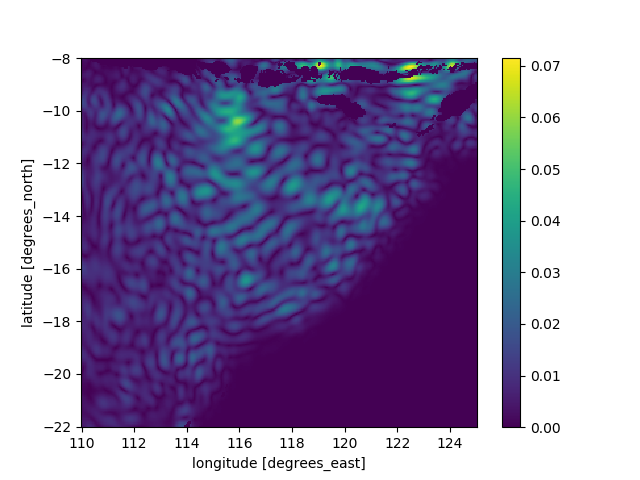

In [59]:
plt.figure()
amp.plot()
plt.gca().set_aspect('equal')

In [116]:
# Make a point prediction

lonpt = 121
latpt = -13.5

#lonpt = 123.346383
#latpt = -13.75895

# M2, K1, S2, O1, MA2, MB2
freqs = [28.9841042, 15.0410686, 30.0000000,13.9430356,28.9841042 + 360/(365.25*24), 28.9841042 - 360/(365.25*24)]
omega = [2*np.pi/(360/ff*3600) for ff in freqs]
omega

[0.00014051890250864362,
 7.292115835787053e-05,
 0.0001454441043328608,
 6.759774415077306e-05,
 0.00014071800463640936,
 0.00014031980038087792]

In [117]:
time = pd.date_range('2016-5-1','2017-5-1',freq='H')
t0 = pd.DatetimeIndex([pd.datetime(1992,1,1)])
dt = time-t0[0]
t = dt.total_seconds().values
t

array([7.678368e+08, 7.678404e+08, 7.678440e+08, ..., 7.993656e+08,
       7.993692e+08, 7.993728e+08])

In [118]:
ptds = ds.sel(longitude=lonpt,latitude=latpt, method='nearest')
ptds

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float64 121.0
    latitude   float64 -13.5
Data variables:
    M2re       float32 -0.0162
    M2im       float32 0.021699999
    K1re       float32 ...
    K1im       float32 ...
    S2re       float32 ...
    S2im       float32 ...
    O1re       float32 ...
    O1im       float32 ...
    MA2re      float32 ...
    MA2im      float32 ...
    MB2re      float32 ...
    MB2im      float32 ...
Attributes:
    Conventions:              CF-1.7
    history:                  merged txa/j1a/j2a/j3a, txb/j1b/j2b, g1a, and e...
    resolution:               The spatial basis function coefficients are def...
    creator:                  Ed Zaron, ezaron@pdx.edu
    post-processing scripts:  baburu:NASA-Tides/Julia/; this file was written...
    scripts:                  namako:NASA-Tides/Julia/ and coeus:NASA-Tides/J...
    notes:                    This model is an update to the Carrere_HRET_tes...
    results:                  bab

In [119]:
datavars = list(ds.data_vars.keys())
datavars

['M2re',
 'M2im',
 'K1re',
 'K1im',
 'S2re',
 'S2im',
 'O1re',
 'O1im',
 'MA2re',
 'MA2im',
 'MB2re',
 'MB2im']

In [120]:
beta = [float(ptds[vv].values) for vv in datavars]
beta

[-0.016200000420212746,
 0.021699998527765274,
 0.0007999999797903001,
 -0.0010999999940395355,
 -0.005400000140070915,
 -9.999999747378752e-05,
 -0.0010000000474974513,
 -0.0010000000474974513,
 -0.0017000000225380063,
 0.0015999999595806003,
 -0.0020000000949949026,
 0.0003000000142492354]

In [121]:
eta = 0
for ii in range(6):
    eta += beta[2*ii]*np.cos(omega[ii]*t) + beta[2*ii+1]*np.sin(omega[ii]*t)

<IPython.core.display.Javascript object>


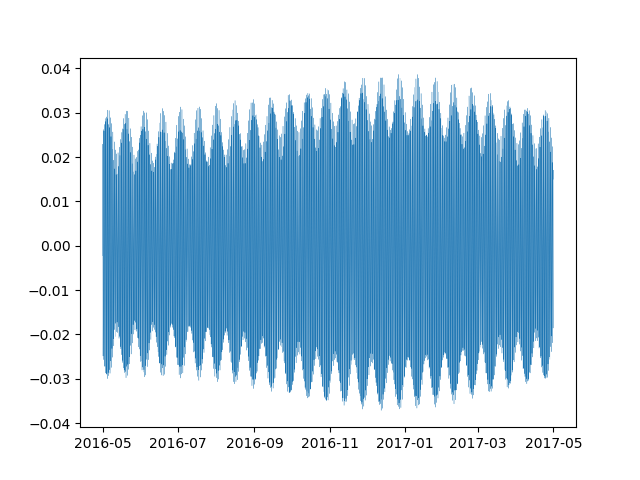

In [122]:
plt.figure()
plt.plot(time,eta,lw=0.2)

In [38]:
# Perform a 2D fft
# Compute the fft
def hilbert_2d(z, dx, dy):
    My, Mx = z.shape
    Z = fft2(z)

    # Compute zonal frequencies
    k = fftfreq(Mx, dx/(2*np.pi))
    dk = 1/(Mx*dx)

    # Compute meridional frequencies
    l = fftfreq(Mx, dx/(2*np.pi))
    dl = 1/(My*dy)
    
    # Create filter matrices for each of the four quadrant
    Z_posk_posl = np.zeros_like(Z)
    Z_posk_posl[:My//2, :Mx//2] = Z[:My//2, :Mx//2] 

    z_posk_posl = ifft2(Z_posk_posl)

    Z_posk_negl = np.zeros_like(Z)
    Z_posk_negl[:My//2, Mx//2::] = Z[:My//2, Mx//2::] 

    z_posk_negl = ifft2(Z_posk_negl)

    Z_negk_negl = np.zeros_like(Z)
    Z_negk_negl[My//2::, Mx//2::] = Z[My//2::, Mx//2::] 

    z_negk_negl = ifft2(Z_negk_negl)

    Z_negk_posl = np.zeros_like(Z)
    Z_negk_posl[My//2::, :Mx//2] = Z[My//2::, :Mx//2] 

    z_negk_posl = ifft2(Z_negk_posl)
    
    return z_posk_posl, z_posk_negl, z_negk_negl, z_negk_posl

In [145]:
dx = ds.longitude.values[1]-ds.longitude.values[0]
dy = ds.latitude.values[1] - ds.latitude.values[0]
X = ds.longitude.values
Y = ds.latitude.values

amp_m2 = ds.M2re.values+1j*ds.M2im.values
amp_NE, amp_NW, amp_SW, amp_SE = hilbert_2d(amp_m2, dx, dy)

amp_s2 = ds.M2re.values+1j*ds.S2im.values
amps2_NE, amps2_NW, amps2_SW, amps2_SE = hilbert_2d(amp_s2, dx, dy)

<IPython.core.display.Javascript object>


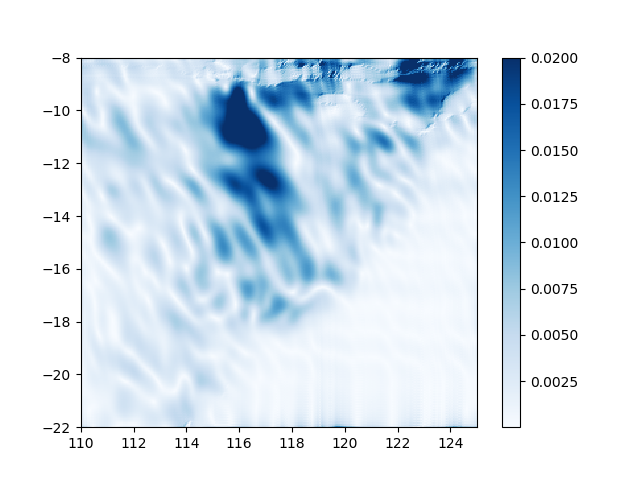

In [159]:
plt.figure()
plt.pcolormesh(X,Y, np.abs(amp_SE), cmap='Blues', vmax=0.02)
plt.gca().set_aspect('equal')
plt.colorbar()

<IPython.core.display.Javascript object>


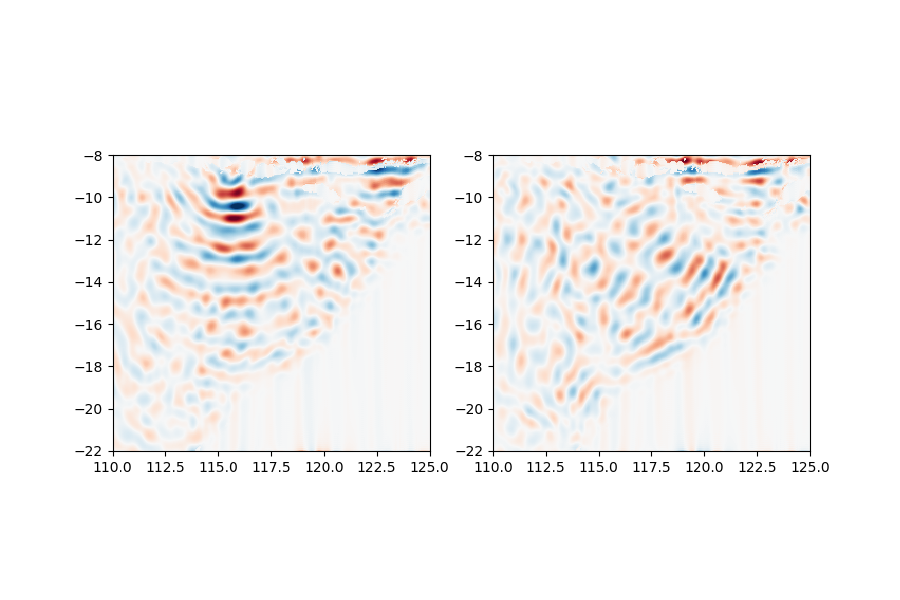

In [161]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

#x = np.linspace(0, 10, 1000)
omegaM2= omega[0]
omegaS2= omega[2]

t = np.linspace(0,2*np.pi/omegaM2,24)
vmax = 0.04
xlims = [110,125]
ylims = [-22,-8]

# create a simple animation
fig = plt.figure(figsize=(9,6))
ax1 = plt.subplot(121, xlim=xlims, ylim=ylims)
ax2 = plt.subplot(122, xlim=xlims, ylim=ylims)

#line, = ax.plot([], [], lw=2)

zdata = np.real(amp_SE*np.exp(1j*omegaM2*0))
zdata += np.real(amp_SW*np.exp(1j*omegaM2*0))

#zdata += np.real(amps2_SE*np.exp(1j*omegaS2*0))

p1=ax1.pcolormesh(X,Y, zdata, cmap='RdBu', vmax=vmax, vmin=-vmax)
ax1.set_aspect('equal')



zdata = np.real(amp_NW*np.exp(1j*omegaM2*0))
zdata += np.real(amp_NE*np.exp(1j*omegaM2*0))

#zdata += np.real(amps2_NW*np.exp(1j*omegaS2*0))

p2=ax2.pcolormesh(X,Y, zdata, cmap='RdBu', vmax=vmax, vmin=-vmax)
ax2.set_aspect('equal')


def init():
    p1.set_array(zdata.ravel())
    p2.set_array(zdata.ravel())

    return p1,p2,

def animate(i):
    zdata = np.real(amp_SE*np.exp(-1j*omegaM2*t[i]))[:-1,:-1]
    zdata += np.real(amp_SW*np.exp(-1j*omegaM2*t[i]))[:-1,:-1]

    #zdata += np.real(amps2_SE*np.exp(-1j*omegaS2*t[i]))[:-1,:-1]


    p1.set_array(zdata.ravel())
       
    zdata = np.real(amp_NW*np.exp(-1j*omegaM2*t[i]))[:-1,:-1]
    zdata += np.real(amp_NE*np.exp(-1j*omegaM2*t[i]))[:-1,:-1]

    #zdata += np.real(amps2_NW*np.exp(-1j*omegaS2*t[i]))[:-1,:-1]

    p2.set_array(zdata.ravel())
    return p1,p2,

anim=animation.FuncAnimation(fig, animate, init_func=init,
                        frames=24, interval=50, blit=True)
